In [67]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked,words2answers
from utils_NLP import words2text
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2

# Stats saving stuff
from utils_EDA import calcstats_train_dev

# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Load and merge ground truth and MODEL data

In [3]:
!pwd

/home/davestanley/Dropbox/git/mindpocket/train_model/articles_batch2.0/model1e0c27


In [4]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [72]:
# Trim down newly loaded articles to match Narticles in training set
ind_train = slice(0,Ntrain)
ind_dev = slice(0,Ndev)

# Chosen display articles
ind_ex_train = 1                   # Example from training set - Chopin
ind_ex_dev = Ntrain + (467-442)    # Example from dev set - Immune system
ind_ex_dev = 105

In [6]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [7]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
if not sum(titles_match_bool) == len(titles_match_bool):
    raise ValueError('Articles mismatch.')


Matching titles: 477 
Total articles 477


In [8]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [9]:
arts[ind_ex_train]['paragraphs'][0]['context']

'Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: \u200b[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.'

In [10]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'


from utils_NLP import allenNLP_classify_blanks
arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [11]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
    if not sum(titles_match_bool) == len(titles_match_bool):
        raise ValueError('Articles mismatch.')

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [12]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [13]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

## AllenNLP Words

In [14]:
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

125
125
The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism 's own healthy tissue. In many species, the immune system can be classified into subsystems, such as the innate immune system versus the adaptive immune system, or humoral immunity versus cell - mediated immunity. In humans, the blood – brain barrier, blood – cerebrospinal fluid barrier, and similar fluid – brain barriers separate the peripheral immune system from the neuroimmune system which protects the brain.
708


## Context

In [15]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


125
The immune system is a system of many biological structures and processes within an organism that protects against disease. To function properly, an immune system must detect a wide variety of agents, known as pathogens, from viruses to parasitic worms, and distinguish them from the organism 's own healthy tissue. In many species, the immune system can be classified into subsystems, such as the innate immune system versus the adaptive immune system, or humoral immunity versus cell - mediated immunity. In humans, the blood – brain barrier, blood – cerebrospinal fluid barrier, and similar fluid – brain barriers separate the peripheral immune system from the neuroimmune system which protects the brain.
708


## Context_blanked

In [16]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

125
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
The immune ______ is a ______ of many biological structures and processes within an organism that protects against ______ . To function properly , an immune ______ must detect a wide variety of agents , known as ______ , from viruses to parasitic worms , and distinguish them from the organism 's own healthy tissue . In many species , the immune ______ can be classified into subsystems , such as the innate immune ______ versus the adaptive immune ______ , or humoral immunity versus cell - mediated immunity . In humans , the blood – brain barrier , blood – cerebrospinal fluid barrier , and similar fluid – brain ______ separate the peripheral immune ______ from the ______ ______ which protects the brain .


In [17]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

system
system
disease
system
pathogens
system
system
system
barriers
system
neuroimmune
system


# Single paragraph - Compare blanks

## First, just look at the raw text

In [69]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [70]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 163. Length ground truth blanks: 163


In [71]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				The
______				______
is				is
an				an
organ				______
that				that
serves				serves
as				as
______				the
center				______
of				of
______				the
nervous				______
system				system
in				in
all				all
vertebrate				______
and				and
most				most
invertebrate				______


## Ground truth blanked

In [21]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

The immune ______ is a ______ of many biological structures and processes within an organism that protects against ______. To function properly, an immune ______ must detect a wide variety of agents, known as ______, from viruses to parasitic worms, and distinguish them from the organism 's own healthy tissue. In many species, the immune ______ can be classified into subsystems, such as the innate immune ______ versus the adaptive immune ______, or humoral immunity versus cell - mediated immunity. In humans, the blood – brain barrier, blood – cerebrospinal fluid barrier, and similar fluid – brain ______ separate the peripheral immune ______ from the ______ ______ which protects the brain.
Answers:
['system', 'system', 'disease', 'system', 'pathogens', 'system', 'system', 'system', 'barriers', 'system', 'neuroimmune', 'system']


In [22]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

The ______ ______ is a system of many ______ ______ and processes within an ______ that ______ against ______. To function ______, an ______ system must detect a wide variety of ______, known as ______, from ______ to ______ ______, and distinguish them from the ______ 's own ______ ______. In many species, the ______ ______ can be classified into ______, such as the ______ ______ system versus the ______ ______ system, or ______ immunity versus cell - mediated immunity. In ______, the ______ – ______ ______, ______ – ______ ______ ______, and similar ______ – ______ ______ separate the ______ ______ system from the ______ ______ which protects the ______.
Answers:
['immune', 'system', 'biological', 'structures', 'organism', 'protects', 'disease', 'properly', 'immune', 'agents', 'pathogens', 'viruses', 'parasitic', 'worms', 'organism', 'healthy', 'tissue', 'immune', 'system', 'subsystems', 'innate', 'immune', 'adaptive', 'immune', 'humoral', 'humans', 'blood', 'brain', 'barrier', 'bloo

In [23]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [24]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.688
0.688
7
34


In [25]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [26]:
print(TPR)
print(FPR)

0.5833333333333334
0.3008849557522124


In [27]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=4
Nsentences_from_words=4


In [28]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

1.75
8.5


# Single article - compare blanks

In [73]:
##### Pull out sample paragraph
a = arts[ind_ex_dev]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Pitch_(music)


In [74]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 1482. Length ground truth blanks: 1482


In [84]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=30
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
print("Original" + '\t\t\t' + "Ground truth" + '\t\t\t' + "Prediction")
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
for o,c,w in zip(words[:N],words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(o + '\t\t\t\t' + c + '\t\t\t\t' + w)


========			============			==========
Original			Ground truth			Prediction
========			============			==========
Pitch				______				______
is				is				is
an				an				an
auditory				______				______
sensation				sensation				______
in				in				in
which				which				which
a				a				a
listener				listener				listener
assigns				assigns				assigns
musical				musical				musical
tones				tones				______
to				to				to
relative				relative				relative
positions				positions				positions
on				on				on
a				a				a
musical				musical				musical
scale				scale				scale
based				based				based
primarily				primarily				primarily
on				on				on
their				their				their
perception				perception				perception
of				of				of
the				the				the
frequency				______				frequency
of				of				of
vibration				vibration				______
.				.				.


In [76]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [77]:
print(ACC)
print(ACC2)

0.8434547908232118
0.8434547908232118


In [78]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [79]:
print(TPR)
print(FPR)

0.711864406779661
0.1510892480674631


In [80]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=53


In [81]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.7924528301886793
4.056603773584905


## Ground truth blanked

In [82]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'sound', 'octave', '1,400', 'indefinite', 'logarithmic', 'pitch', 'generated', '60.5', 'rapid', 'ambiguities', 'spelling', 'frequency', 'unnecessary', 'Frequency', 'snare', 'overtones', 'numerical', 'missing', 'Pitch', '100', 'numerous', 'two', 'A4', 'slower', '1', '12', 'auditory', 'fundamental', 'partials', 'drum', '69', 'ambiguous'}


In [83]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'sound', 'oscillation', 'frequencies', 'human', 'chroma', 'beat', 'pitch', 'intensity', 'low', 'one', 'repetition', 'sounds', 'G4', 'spelling', 'wave', 'keyboards', 'conceptual', 'sensation', '16,000', 'potentials', 'Frequencies', 'succession', 'tuning', 'multiples', 'etymological', 'threshold', 'western', 'MIDI', 'systems', '69', '1.05946', 'Hz', 'vertical', 'cochlea', 'root', 'pure', 'bass', 'twelve', 'insensitive', 'physical', 'sharp', 'lower', '0.6', 'ambiguities', 'p', 'C♯', 'nature', 'unnecessary', 'Frequency', 'snare', 'filters', '61', 'overtones', 'humans', 'basic', 'prerequisite', 'west', 'English', 'proxy', 'elicit', 'A4', '12', 'Sebastian', 'A880', 'mechanism', 'fundamental', 'partials', '200', 'drum', 'observer', 'intervals', 'tones', 'keys', 'cents', '16', 'Harmonics', 'octave', '1,400', '1200', 'microtones', 'amplitude', 'measurement', 'percept', 'stimulus', 'height', 'A440', 'upper', 'semitones', 'peak', '500', 'successive', 'phenomenon', 'perception', 'middle'

# All articles - compare blanks

In [40]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads
sbc0 = []
st0 = []
Nwords0 = []

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))

    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))

        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100

        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2

    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    sbc0.append(sbc)
    st0.append(st)
    Nwords0.append(len(tags))

Warning article 175 contains 0 ground truth blanks and 505 tags. Likely bad
Warning article 440 contains 0 ground truth blanks and 717 tags. Likely bad
Warning article 441 contains 0 ground truth blanks and 714 tags. Likely bad


In [41]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

Bill_%26_Melinda_Gates_Foundation
Myocardial_infarction
Matter


In [42]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print('Ntrain={}'.format(str(Ntrain)))
print('Ndev={}'.format(str(Ndev)))
print('Ntrain_bad={}'.format(str(Ntrain_bad)))
print('Ndev_bad={}'.format(str(Ndev_bad)))




Ntrain=442
Ndev=35
Ntrain_bad=3
Ndev_bad=0


## Plot TPR

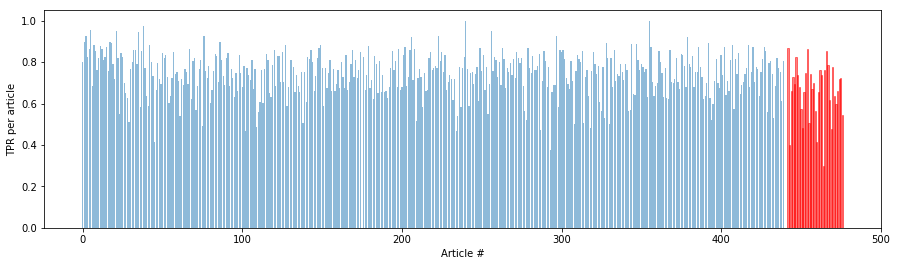

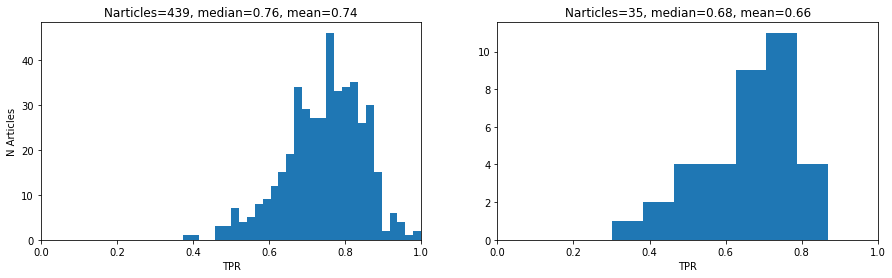

In [43]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot FPR

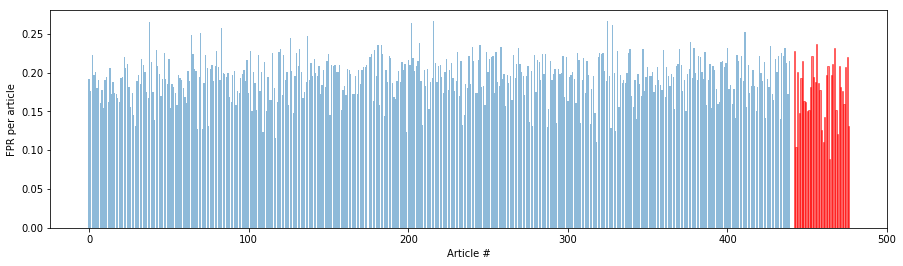

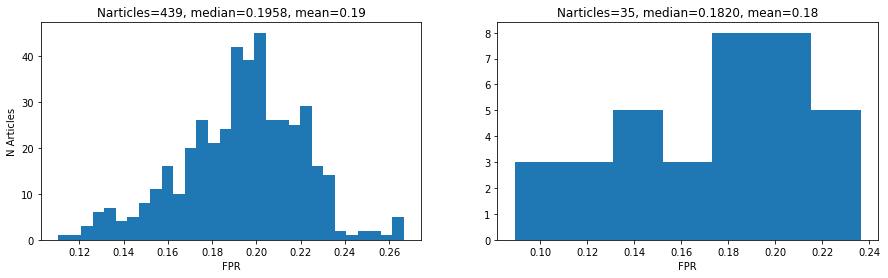

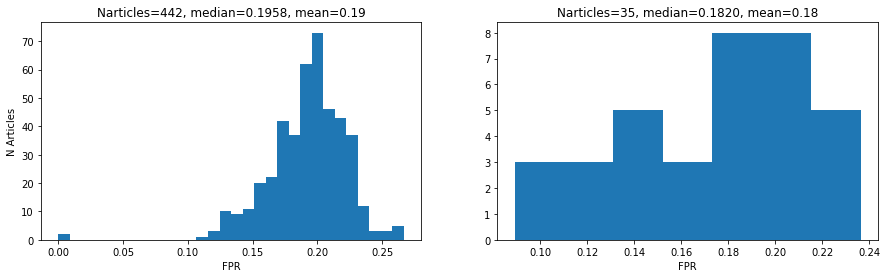

In [44]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

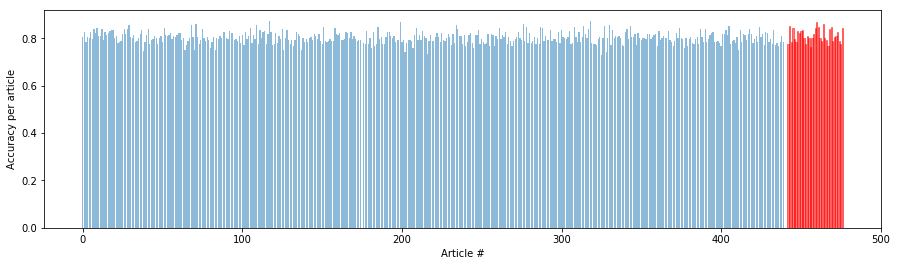

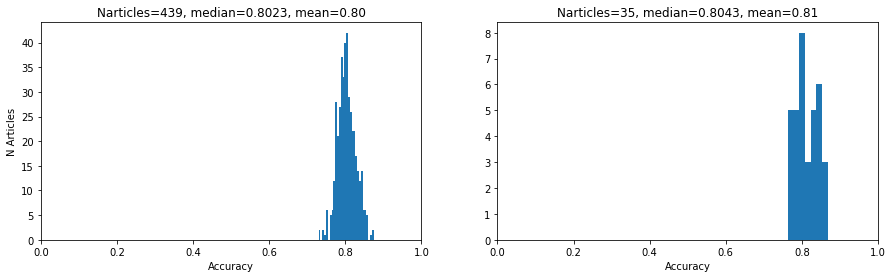

In [45]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

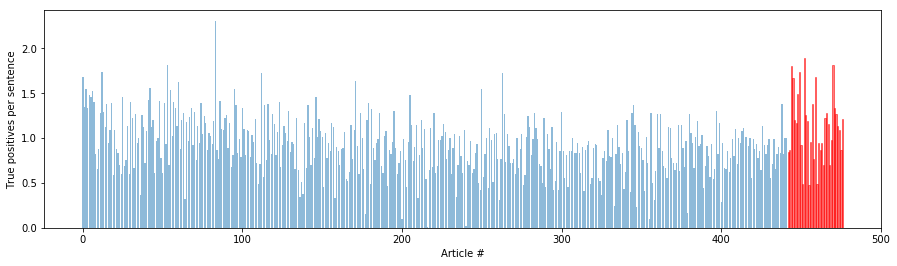

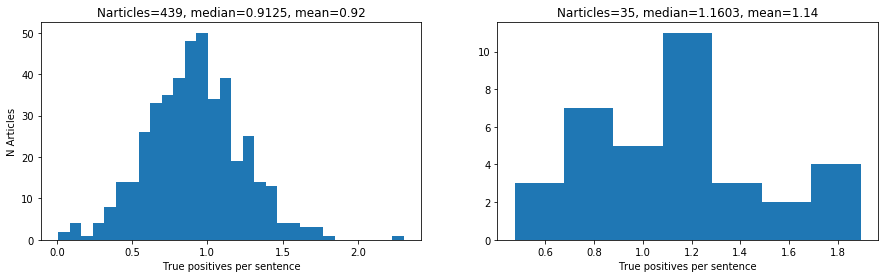

In [46]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

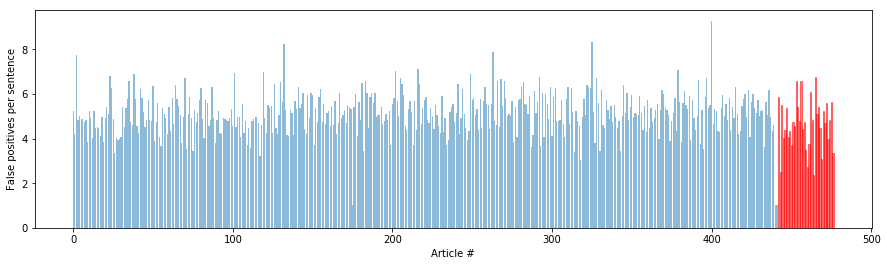

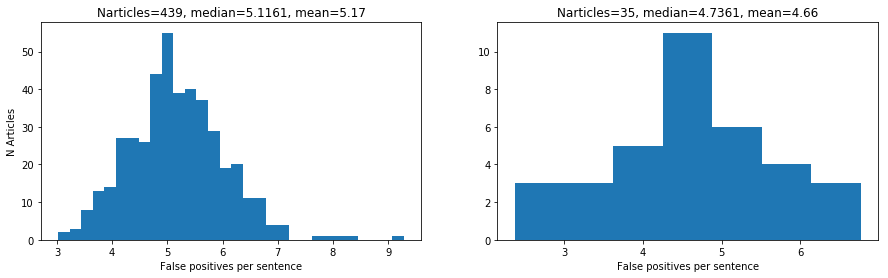

In [47]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [48]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

34
Article #476
Computational_complexity_theory
True positive rate: 0.39767441860465114


In [49]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Computational_complexity_theory


In [50]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				Computational
complexity				complexity
theory				theory
is				is
a				a
branch				branch
of				of
the				the
theory				theory
of				of
computation				______
in				in
theoretical				theoretical
computer				computer
science				science
that				that
focuses				focuses
on				on
classifying				classifying
______				______


## Ground truth blanked

In [51]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'algorithm', 'inherent', 'NL', 'NC', 'Boolean', 'matrices', 'EXPTIME', 'Cobham', 'Ladner', 'binary', 'deterministically', 'problem', 'computers', 'storage', 'power', 'arithmetic', 'size', 'knapsack', 'laid', 'complex', 'bits', 'reduces', 'solutions', 'Alan', 'output', 'function', 'complicated', 'complexity', 'triple', 'framework', 'second', 'computability', 'suspected', 'models', 'equal', 'number', 'multiplication', 'written', 'symbols', '21', 'solution', 'Algorithms', 'lower', 'P', 'Presburger', 'triples', 'Turing', 'transitions', 'bound', 'integer', 'intractable', 'space', 'Yamada', 'measure', 'measures', 'bounds', 'language', 'encoding', 'single', '1965', 'problems', 'reductions', 'memory', 'alphabet', 'bitstrings', 'mathematical', 'reversed', '1961', 'level', 'another', 'NP', 'hierarchy', 'worst', 'unusual', 'quantitative', 'Manuel', 'rules', 'gates', 'probabilistic', 'resource', 'instances', 'possible', 'thesis', 'RSA', 'quicksort', 'bounding', 'theorem', 'analysis', 'ad

In [52]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'algorithm', 'NL', 'paper', 'NC', 'Combinatorial', 'Boolean', '2O(√(n', 'Boris', 'steps', 'Upper', 'matrices', 'EXPTIME', 'Cobham', 'Ladner', 'RAM', 'binary', 'Karp', 'deterministically', 'ZPP', 'tape', 'problem', 'Clay', 'one', 'Raymond', 'PH', 'processors', 'realizable', 'half', 'DTIME(n2', 'Richard', '1956', '1.2', 'theoretical', 'Conway', 'captures', 'axioms', 'transformation', 'path', 'arithmetic', 'n.log', 'everything', 'reverse', 'xx', 'n15', 'SAT', 'pivoting', 'size', 'knapsack', 'Babai', 'magnitude', 'literature', 'P.', 'seminal', 'bits', 'supercomputer', '≠', 'Analogous', '1,000,000', 'O(e(64/9)1/3(n.log', 'Alan', 'biology', 'prediction', 'squaring', 'n.', 'Reducibility', '1967', 'complexity', 'intractability', 'triple', 'divides', 'framework', 'computability', 'Germany', 'QMA', 'cryptographic', 'finite', 'multiplication', 'Life', 'way', 'branches', 'Again', 'symbols', 'Y.', '21', 'Algorithms', 'lower', 'Presburger', 'C', 'P', 'Laszlo', 'solvers', 'triples', 'Turing

# All paragraphs - compare blanks

In [53]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [54]:
FPR0[0:10]

[0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891,
 0.1305551033696891]

In [55]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [56]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


19035
1204
1383
13


## Plot TPR

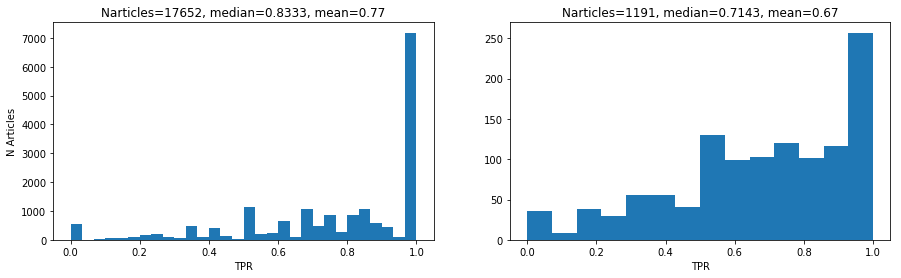

In [57]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [58]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

756
Article #442 paragraph #1
Normans
True positive rate: 0.7142857142857143


In [59]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [60]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
Norman				______
dynasty				______
had				had
a				a
major				major
political				political
,				,
cultural				cultural
and				and
military				military
impact				impact
on				on
medieval				______
Europe				______
and				and
even				even
the				the
Near				______
East				______


## Ground truth blanked

In [61]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the ______ ______ into which they assimilated. They adopted the Gallo - Romance language of the Frankish land they settled, their dialect becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy of Normandy, which they formed by treaty with the French crown, was a great fief of medieval France, and under ______ ______ of Normandy was forged into a cohesive and formidable principality in feudal tenure. The Normans are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy on the Saracens and Byzantines, and an expedition on

In [62]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

The ______ ______ had a major political, cultural and military impact on ______ ______ and even the ______ ______. The ______ were famed for their ______ ______ and eventually for their ______ ______, becoming exponents of the ______ ______ into which they assimilated. They adopted the ______ - ______ language of the ______ land they settled, their dialect becoming known as ______, ______ or ______ ______, an important literary language. The ______ of ______, which they formed by ______ with the ______ crown, was a great fief of ______ ______, and under ______ I of ______ was forged into a ______ and formidable ______ in ______ ______. The ______ are noted both for their ______, such as their unique ______ ______ and musical ______, and for their significant military accomplishments and innovations. ______ ______ founded the Kingdom of ______ under ______ ______ after conquering ______ ______ on the ______ and ______, and an ______ on behalf of their duke, ______ the ______, led to the

In [63]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [64]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.7261904761904762
0.7261904761904762
5
67


In [65]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [66]:
print(TPR)
print(FPR)

0.7142857142857143
0.27346938775510204
